Target:```To keep the model same but change the learning rate scheduling part .This current learning rate scheduler accepts a start_lr and end_lr and gradually reduces the lr as the epochs pass in order to achieve higher accuracy numbers faster```

Result: ```The accuracy cross 99.4 thrice```


Analysis: ```The judgement of understanding the model's capability of performing well was right ,but the place model was lacking is that it wanted to achieve the accuracy numbers fast but because of the constant learning rate policy we did not allow it to happen fast```

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [192]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
#                                        transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [193]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [194]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [279]:
class conv_block(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=(3,3),dropout=0.1,**kwargs):
    super(conv_block, self).__init__()
    self.convblock = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,**kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        )
    # self.out_channels=out_channels
  def forward(self,x):
    return self.convblock(x)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1=conv_block(in_channels=1,out_channels=16,padding=0)
        self.conv2=conv_block(in_channels=16,out_channels=16,padding=0)
        
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.conv3=conv_block(in_channels=16,out_channels=10,padding=0,kernel_size=(1,1))
        
        self.conv4=conv_block(in_channels=10,out_channels=16,padding=0)
        self.conv5=conv_block(in_channels=16,out_channels=16,padding=0)
        
        self.conv6=conv_block(in_channels=16,out_channels=10,dropout=0.0,padding=0)
#         self.conv7=conv_block(in_channels=14,out_channels=10,dropout=0.0,kernel_size=(5,5),padding=0)
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        )
        self.fc1=nn.Linear(10,10)

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.pool1(x)
        x= self.conv3(x)
        x= self.conv4(x)
        x= self.conv5(x)
        x= self.conv6(x)
        x= self.gap(x)
        x = x.view(-1, 10)
        x=self.fc1(x)

#         x=self.conv8(x)
        
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [280]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
        conv_block-5           [-1, 16, 26, 26]               0
            Conv2d-6           [-1, 16, 24, 24]           2,320
       BatchNorm2d-7           [-1, 16, 24, 24]              32
              ReLU-8           [-1, 16, 24, 24]               0
           Dropout-9           [-1, 16, 24, 24]               0
       conv_block-10           [-1, 16, 24, 24]               0
        MaxPool2d-11           [-1, 16, 12, 12]               0
           Conv2d-12           [-1, 10, 12, 12]             170
      BatchNorm2d-13           [-1, 10, 12, 12]              20
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [281]:
from tqdm import tqdm_notebook,tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader,position=0)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)
    # print(data.shape)
    # Init
    # scheduler.step()
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    # scheduler.step()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    # print(f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [304]:
from torch.optim.lr_scheduler import StepLR,LambdaLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

start=0.1
end=0.001
diff=(start-end)/EPOCHS
li=[start-i*diff for i in range(1,EPOCHS+1)]

def get_lr(epoch):
    return li[epoch]
    

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    optimizer.param_groups[0]["lr"]=get_lr(epoch)
    print(optimizer.param_groups[0]["lr"])
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.07433505356311798 Batch_id=468 Accuracy=90.69: 100%|██████████| 469/469 [00:04<00:00, 107.26it/s] 

0.09340000000000001



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9862/10000 (98.62%)

EPOCH: 1


Loss=0.05140126869082451 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:04<00:00, 104.18it/s] 

0.0868



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9870/10000 (98.70%)

EPOCH: 2


Loss=0.03596590459346771 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:04<00:00, 101.20it/s] 

0.08020000000000001



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9908/10000 (99.08%)

EPOCH: 3


Loss=0.17748291790485382 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:04<00:00, 94.85it/s]   


0.0736


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9897/10000 (98.97%)

EPOCH: 4


Loss=0.022702088579535484 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:04<00:00, 96.50it/s] 

0.067



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9913/10000 (99.13%)

EPOCH: 5


Loss=0.012851904146373272 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:04<00:00, 94.57it/s]  

0.06040000000000001



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9920/10000 (99.20%)

EPOCH: 6


Loss=0.026890292763710022 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:05<00:00, 87.94it/s] 

0.05380000000000001



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.03440098837018013 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:05<00:00, 82.64it/s]  

0.047200000000000006



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.06519802659749985 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:05<00:00, 81.42it/s]  

0.040600000000000004



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.0272421482950449 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:05<00:00, 79.55it/s]   

0.034



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.11610754579305649 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:06<00:00, 71.98it/s]  

0.027400000000000008



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.050338465720415115 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:06<00:00, 77.69it/s] 

0.020800000000000013



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9943/10000 (99.43%)

EPOCH: 12


Loss=0.04457828402519226 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:10<00:00, 44.99it/s]  

0.014200000000000004



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.012770150788128376 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:07<00:00, 59.23it/s] 

0.0076000000000000095



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.04766691103577614 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:12<00:00, 37.16it/s]  

0.0010000000000000009



Test set: Average loss: 0.0192, Accuracy: 9946/10000 (99.46%)



In [301]:
li=[start-i*diff for i in range(1,16)]


# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

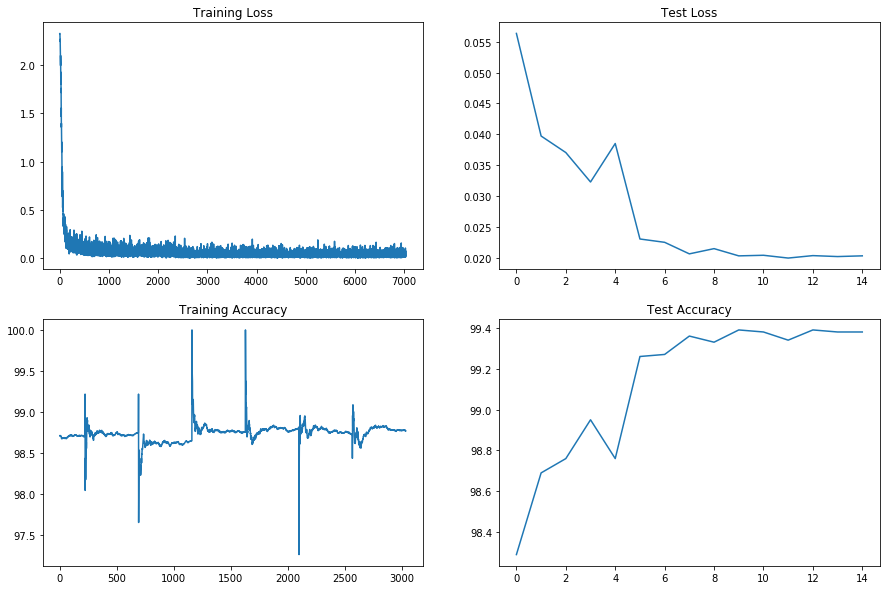

In [232]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Miclassification Analysis

In [233]:
def find_misclassified(model, device, test_loader):
    model.eval()
    test_loss = 0
    misclassified=[]
    correct = 0
    actual=[]
    pred=[]
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            out=torch.argmax(output,axis=1)
            temp=[target.ne(out)]
            
            misclassified.extend(data[temp])
            actual.extend(target[temp])
            pred.extend(out[temp])
            
    return misclassified,actual,pred

In [234]:
mis,actual,pred=find_misclassified(model,device,test_loader)

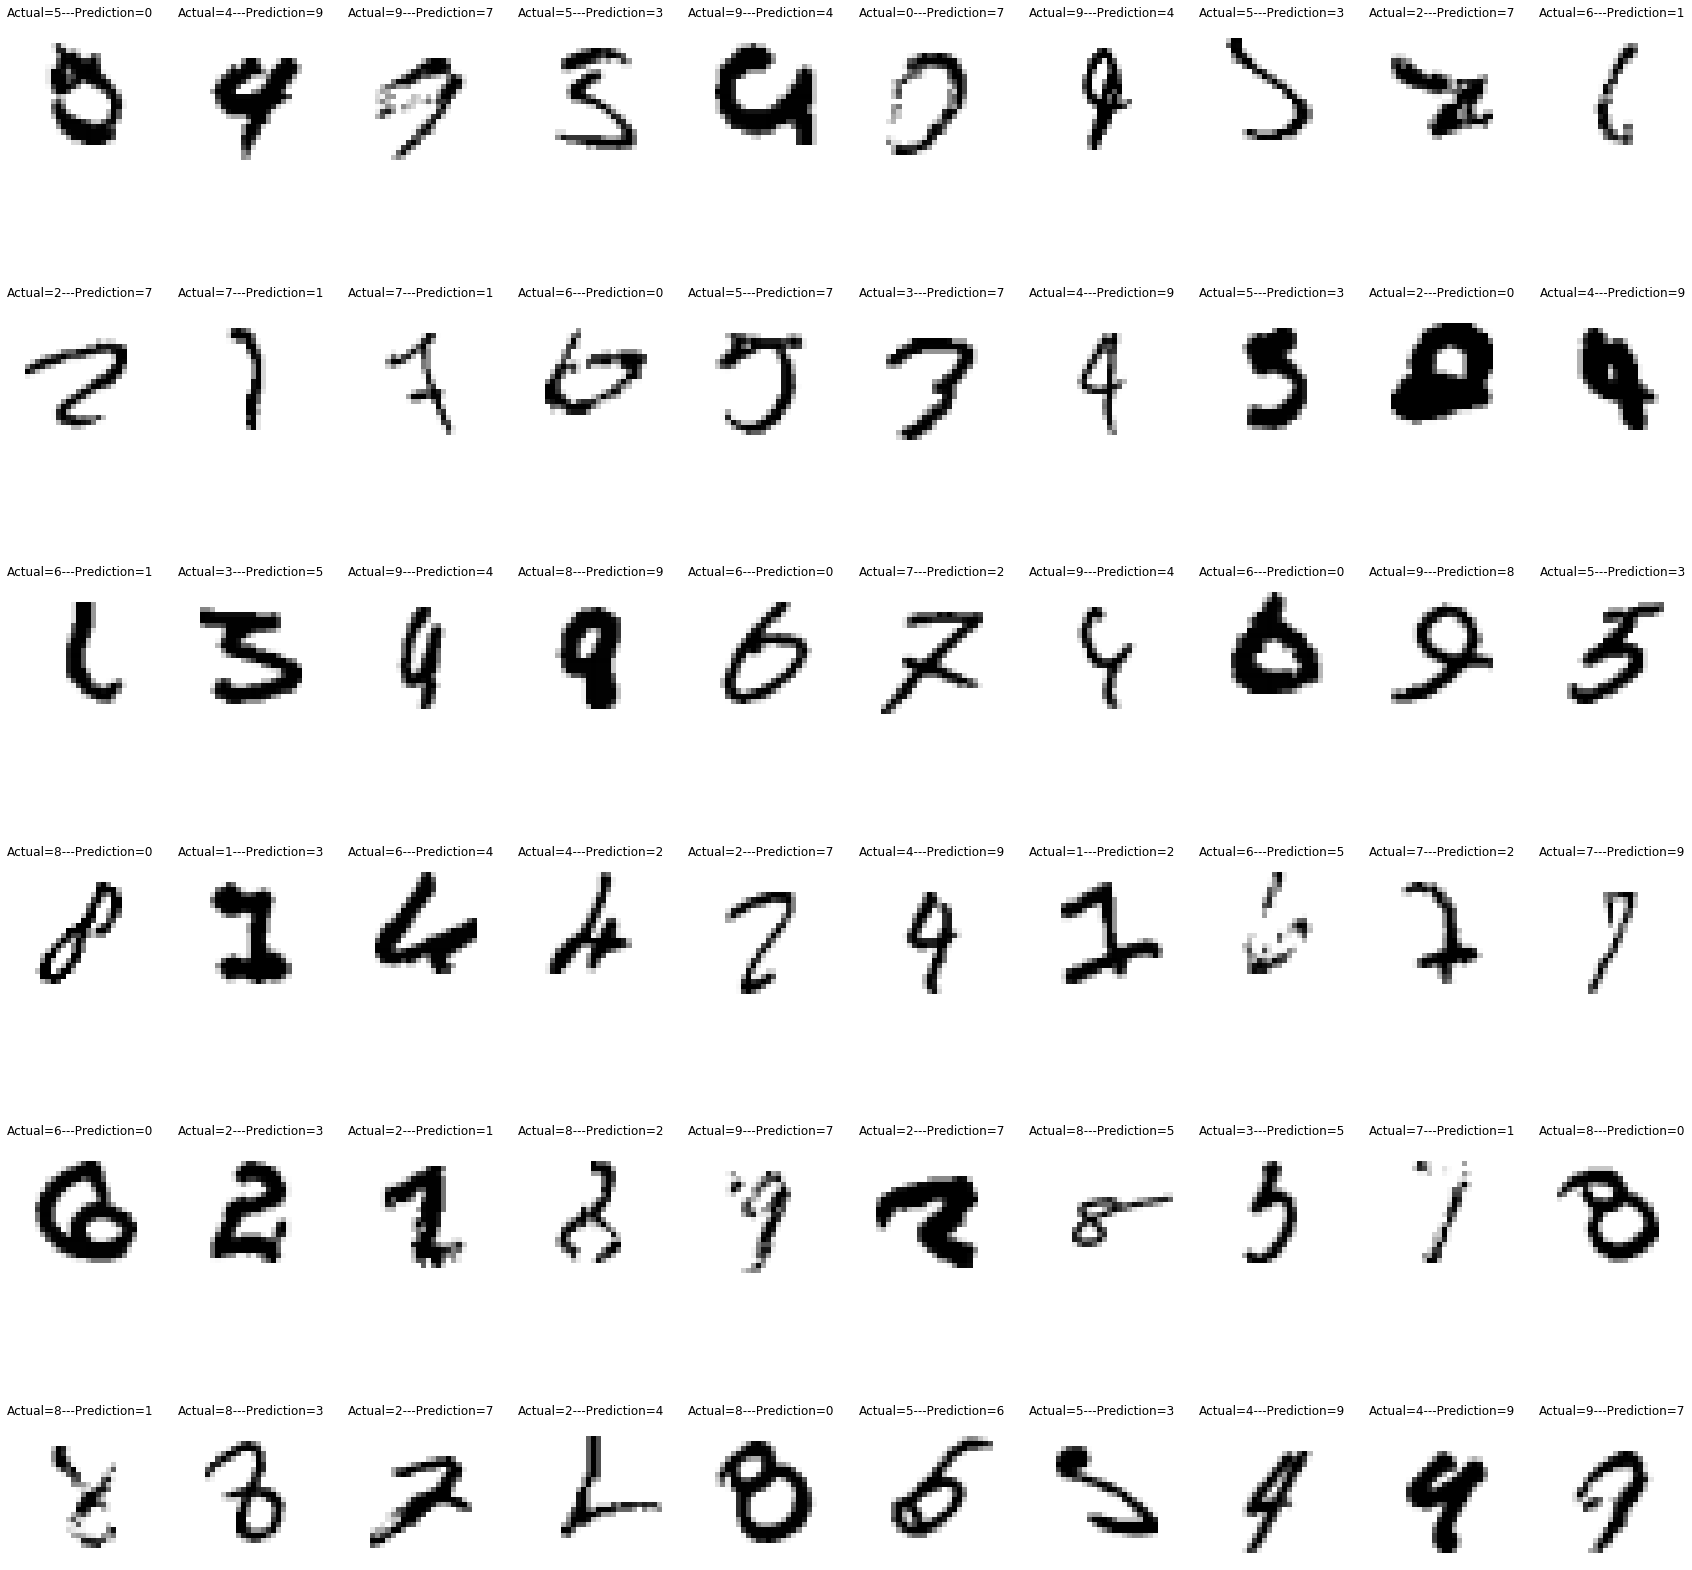

In [236]:
figure = plt.figure(figsize=(30,30))
num_of_images = 60
for index in range(0, num_of_images ):
    plt.subplot(6, 10, index+1)
    plt.axis('off')
    plt.title(f"Actual={actual[index]}---Prediction={pred[index]}")
    plt.imshow(mis[index].cpu().numpy().squeeze(), cmap='gray_r')